In [1]:
%matplotlib inline

import os

import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint
import pandas as pd
BASE_DIR = "/Users/omerkarin/Desktop/covid19/2_day_workweek"


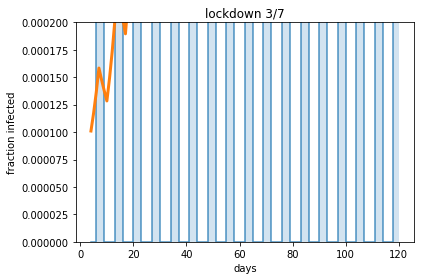

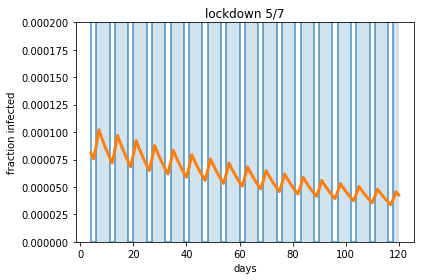

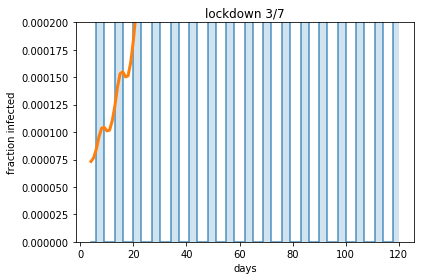

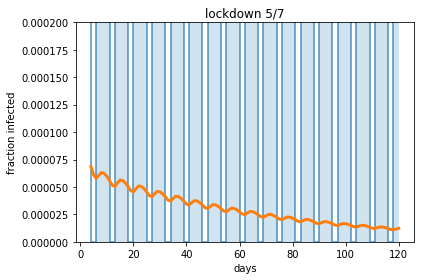

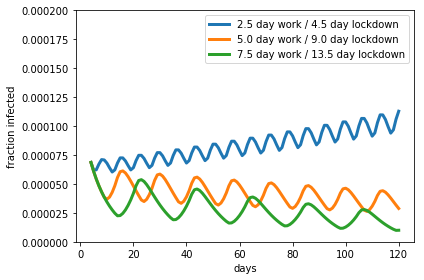

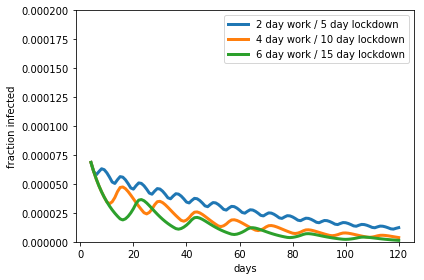

In [4]:
config = {"Tinc" : 5,"Tinf" : 3,"beta" : 1/10,"gamma":1/10}
SEIR_y0 = [1,0.0001,0.0001,0]
SIR_y0 = [1,0.0001,0]
def SIR_model(y,t,config,rfunc):
    S,I,R = y
    Rt = rfunc(t)
    beta,gamma = config["beta"],config["gamma"]
    dydt = [-Rt*beta * (I*S),
            Rt*beta * (I*S) - gamma*I, 
            gamma*I]
    return dydt

def SEIR_model(y,t,config,rfunc):
    S,E,I,R = y
    Tinc,Tinf = config["Tinc"],config["Tinf"]
    Rt = rfunc(t)
    dydt = [-Rt/Tinf * (I*S),
            Rt/Tinf * (I*S) - (1/Tinc)*E, 
            (1/Tinc)*E - (1/Tinf)*I,
            (1/Tinf)*I]
    return dydt

def run(ax,model,config,y0,PERIOD,ISOLATION,Rf=2.5,Rl=0.3,verbose=True,plot_period=False):
    
    frac_0 = y0[-2]
    tmax_start = 5    
    tmax = 30 * 4
    t = np.linspace(1,tmax,tmax)
    rfunc = lambda t:  Rl+(Rf-Rl)*((t%PERIOD) >= ISOLATION)
    rfunc=np.vectorize(rfunc)

    sol = odeint(model, y0, t,args=(config,rfunc), atol=1e-12, rtol=1e-12)

    if verbose: 
        TSTART = 3
        if plot_period:
            u_step = frac_0*2.1*(((rfunc(t[TSTART:])-Rl)/(Rf-Rl) + 1)%2)
            ax.step(t[TSTART:],u_step, alpha=0.8)
            ax.fill_between(t[TSTART:],u_step,step="pre", alpha=0.2)
            ax.set_ylim(0,frac_0*2)
        else:
            ax.set_ylim(0,frac_0*2)
        
        ax.plot(t[TSTART:],sol[TSTART:,-2],lw=3)
        ax.set_ylabel("fraction infected")
        ax.set_xlabel("days")
        
for model,y0,name in zip((SIR_model,SEIR_model),(SIR_y0,SEIR_y0),("SIR","SEIR")):
    for ISOLATION in (3,5):
        fig,ax = plt.subplots()
        PERIOD = 7
        legend = []
        run(ax,model,config,y0,PERIOD=PERIOD,ISOLATION=ISOLATION,plot_period=True)
        ax.set_title("lockdown %.0f/%.0f" % (ISOLATION,PERIOD))
        plt.tight_layout()
        plt.savefig(os.path.join(BASE_DIR,"uri_plots","%s_%s_%s.png" % (name,ISOLATION,PERIOD)))

for ISOLATION in (4.5,5):
    
    fig,ax = plt.subplots()
    PERIOD = 7
    legend = []
    for i in range(1,4):
        run(ax,SEIR_model,config,SEIR_y0,PERIOD=PERIOD*i,ISOLATION=ISOLATION*i)
        if ISOLATION==int(ISOLATION):
            legend.append("%.0f day work / %.0f day lockdown" % ((PERIOD-ISOLATION)*i,ISOLATION*i,))
        else:
            legend.append("%.1f day work / %.1f day lockdown" % ((PERIOD-ISOLATION)*i,ISOLATION*i,))
    ax.legend(legend)
    plt.tight_layout()
    plt.savefig(os.path.join(BASE_DIR,"uri_plots","ALTERNATING_%s_%s.png" % (ISOLATION,PERIOD)))